In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from concurrent.futures import ProcessPoolExecutor

from parsers import vulnerability_parser, attack_graph_parser, topology_parser
from mio import wrappers

__version__ = "1.0-dev2"

argv=['', 'examples/full-conn/10-example']


Initial Configurations

In [2]:
stat, config, example_folder, result_folder, times = wrappers.init(argv)

assert stat == 0


Parsing the topology of docker-compose file

In [3]:
networks, services, gateway_nodes = topology_parser.parse_topology(example_folder)

networks: dict[str, dict[str, set]]
services: dict[str, dict[str, ]]
gateway_nodes: set[str]

Executing the topology parser...
Time elapsed: 0.006116151809692383 seconds.




create topology in format of dictionary of lists

In [4]:
topology_graph, gateway_graph, gateway_graph_labels = topology_parser.create_graphs(networks, services)

topology_graph: nx.Graph
gateway_graph: nx.Graph
gateway_graph_labels: dict[(str, str), str]

{('exposed', 'frontend'): Text(0.0, 0.0, 'tc')}

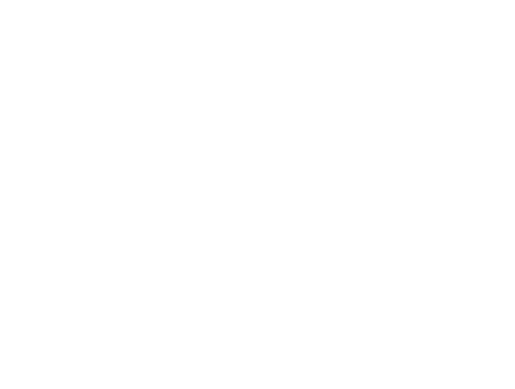

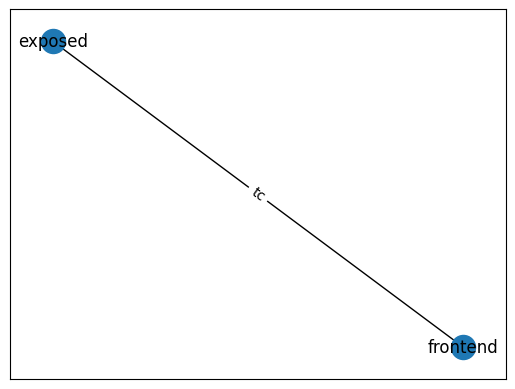

In [15]:
plt.axis("off")

plt.figure()
pos = nx.spring_layout(gateway_graph)
nx.draw_networkx_nodes(gateway_graph, pos)
nx.draw_networkx_edges(gateway_graph, pos)
nx.draw_networkx_labels(gateway_graph, pos)
nx.draw_networkx_edge_labels(gateway_graph, pos, edge_labels=gateway_graph_labels)


Parsing the vulnerabilities for each docker container

In [11]:
stat, vulnerabilities, parsed_images, duration_vulnerabilities = vulnerability_parser. \
        parse_vulnerabilities(example_folder, services)

assert stat == 0

vulnerabilities: dict[str, dict[str, ]]
parsed_images: set[str]

Executing the vulnerability parser...
Vulnerability parser executed.
Time elapsed: 0.016881942749023438 seconds.




Merging the attack vector files and creating an attack vector dictionary.

In [12]:
exploitable_vulnerabilities, dvp = attack_graph_parser.get_exploitable_vulnerabilities(
        services, vulnerabilities, config["attack-vector-folder-path"], config["preconditions-rules"], config["postconditions-rules"])

exploitable_vulnerabilities: dict[str, dict[str, dict[str, int]]]

Pre-processing vulnerabilitles...
Total 129 vulnerabilities in container py1.
Total 129 vulnerabilities in container py10.
Total 129 vulnerabilities in container py2.
Total 129 vulnerabilities in container py3.
Total 129 vulnerabilities in container py4.
Total 129 vulnerabilities in container py5.
Total 129 vulnerabilities in container py6.
Total 129 vulnerabilities in container py7.
Total 129 vulnerabilities in container py8.
Total 129 vulnerabilities in container py9.
Total 138 vulnerabilities in container tc.
Vulnerabilities preprocessing finished. Time elapsed: 37.21356010437012 seconds.




Getting the attack graph nodes and edges from the attack paths.

In [12]:
executor = ProcessPoolExecutor()

nodes, edges, passed_nodes, passed_edges, duration_bdf = attack_graph_parser.\
        generate_attack_graph(networks, services, gateway_graph, exploitable_vulnerabilities, executor)

print("Time elapsed: " + str(duration_bdf + dvp) + " seconds.\n")

duration_graph_properties, attack_graph = attack_graph_parser. \
    print_graph_properties(config["labels_edges"], nodes, edges)

attack_graph: nx.DiGraph

for element in edges.keys():
    edges[element] = [edges[element][0]]


NameError: name 'topology' is not defined


Visualizing the attack graph

In [ ]:


time = wrappers.visualise(topology_graph, gateway_graph, gateway_graph_labels, attack_graph, result_folder, times)

print("Time elapsed: " + time + " seconds.\n")

times += 1


Printing time summary of the attack graph generation.v

In [ ]:
wrappers.print_summary(topology_graph.number_of_nodes(),
                               topology_graph.number_of_edges(),
                               attack_graph.number_of_nodes(),
                               attack_graph.number_of_edges())


add container to a network

name = 'test'
image = 'nginx'
network = ['db', 'backend']

wrappers.add_node(name, image, network, vulnerabilities, parsed_images, example_folder, networks, topology,
         topology_graph, services, mapping_names, attack_vector_dict, config, nodes, edges,
         passed_nodes, passed_edges, attack_graph)


delete container by name

name = 'test'
wrappers.del_node(name, networks, topology, services, mapping_names, nodes, edges, passed_nodes, passed_edges, attack_graph)


add honeypot nodes


to = 'goal'
minimum = 3

path_counts = wrappers.gen_defence_list(attack_graph, to)
wrappers.deploy_honeypot(path_counts, minimum, vulnerabilities, parsed_images, example_folder, networks,
                         topology, topology_graph, services, mapping_names, attack_vector_dict, config,
                         nodes, edges, passed_nodes, passed_edges, attack_graph)